## NN datos balanceados undersampling



25.0
900


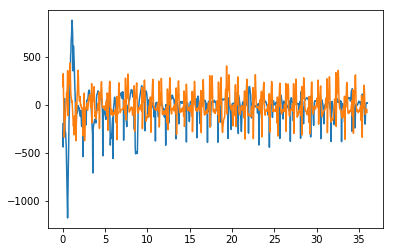

In [44]:
#load data
#load data
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#Decimamos

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

t = np.arange(len(X_train[0]))/250
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal


freq = 250/10#Hz
print(freq)
secs = len(X_train[200])/250
samps = int(secs*freq)
c = 0
X_new = np.zeros((X_train.shape[0],samps))
X_new_test = np.zeros((X_test.shape[0],samps))
for x,x_test in zip(X_train,X_test):
    X_new[c,:] = signal.decimate(x,10,ftype = 'fir')
    X_new_test[c,:] = signal.decimate(x_test,10,ftype = 'fir')
    
    c += 1
    
t = np.arange(len(X_new[200]))/freq
plt.plot(t,X_new[200,:])
print(len(X_new[0]))

X_train = X_new.copy()
X_test = X_new_test.copy()

In [45]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)

In [46]:
#Vamos a probar balanceando con under sampling y over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


In [97]:
#función para crear un modelo de un número determinado de capas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import initializers
from keras.layers.normalization import BatchNormalization
import keras


#f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model(N,n_hidd = [2,2,2]):
    """
    Modelo de red neuronal. 
    
    N: number of input featurs
    n_hidd indica la arquitectura del modelo: n_cols = número de capas, value for eahc col, the number of hidden
    units
    """
    
    model = Sequential()
    
    #input layer
    model.add(Dense(n_hidd[0],input_dim = N,activation = 'relu'))
    model.add(BatchNormalization())
    
    #hidden layers
    for n_h in n_hidd[1:]:
        model.add(Dense(n_h,activation='relu',kernel_initializer=initializers.he_normal(seed=None)))
        model.add(BatchNormalization())  
        #model.add(Dropout(0.8))
        
    #output layer
    model.add(Dense(4,activation = 'softmax'))
   

    opt =keras.optimizers.Adam(lr = 4e-3)
    #compile model
    model.compile(loss='categorical_crossentropy',optimizer = opt,metrics = ['accuracy',f1])
    return model

In [98]:
## dev and train split

#Split data into dev and trin
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

#WARNING que volvemos a llamar train
for train, dev in skf.split(X_resampled,y_resampled):
    X_train, X_dev = X_resampled[train], X_resampled[dev]
    y_train, y_dev = y_resampled[train], y_resampled[dev]
    
print(X_train.shape)
print(X_dev.shape)

(320, 900)
(80, 900)


In [99]:
#Entrenamos el modelo 

N = X_train.shape[1]#number of features
n_h = [int(N/2),int(N/4),int(N/8),int(N/16),int(N/32)]
print(n_h)
print(N)
model = KerasClassifier(build_fn = create_model,N=N,n_hidd=n_h,epochs = 500, batch_size = 10, verbose = 1)

history = model.fit(X_train,y_train)

[450, 225, 112, 56, 28]
900
Epoch 1/500
320/320 [==============================] - 5s 14ms/step - loss: 1.7025 - acc: 0.1938 - f1: 0.0756
Epoch 2/500
320/320 [==============================] - 1s 2ms/step - loss: 1.4068 - acc: 0.2719 - f1: 0.0653
Epoch 3/500
320/320 [==============================] - 1s 2ms/step - loss: 1.3332 - acc: 0.3313 - f1: 0.0976
Epoch 4/500
320/320 [==============================] - 1s 2ms/step - loss: 1.3605 - acc: 0.2813 - f1: 0.0867
Epoch 5/500
320/320 [==============================] - 1s 2ms/step - loss: 1.3232 - acc: 0.2844 - f1: 0.1280
Epoch 6/500
320/320 [==============================] - 1s 2ms/step - loss: 1.2726 - acc: 0.3469 - f1: 0.1799
Epoch 7/500
320/320 [==============================] - 1s 2ms/step - loss: 1.2903 - acc: 0.3344 - f1: 0.1997
Epoch 8/500
320/320 [==============================] - 1s 2ms/step - loss: 1.2886 - acc: 0.3281 - f1: 0.2287
Epoch 9/500
320/320 [==============================] - 1s 2ms/step - loss: 1.2897 - acc: 0.3219 - f

320/320 [==============================] - 1s 2ms/step - loss: 1.1246 - acc: 0.4156 - f1: 0.3582
Epoch 76/500
320/320 [==============================] - 0s 1ms/step - loss: 1.1445 - acc: 0.4281 - f1: 0.3368
Epoch 77/500
320/320 [==============================] - 1s 2ms/step - loss: 1.1032 - acc: 0.4031 - f1: 0.3580
Epoch 78/500
320/320 [==============================] - 0s 2ms/step - loss: 1.1082 - acc: 0.4250 - f1: 0.3670
Epoch 79/500
320/320 [==============================] - 1s 2ms/step - loss: 1.0941 - acc: 0.4063 - f1: 0.3426
Epoch 80/500
320/320 [==============================] - 1s 2ms/step - loss: 1.1623 - acc: 0.4156 - f1: 0.3175
Epoch 81/500
320/320 [==============================] - 1s 2ms/step - loss: 1.1133 - acc: 0.4313 - f1: 0.3860
Epoch 82/500
320/320 [==============================] - 1s 4ms/step - loss: 1.0812 - acc: 0.4406 - f1: 0.3597
Epoch 83/500
320/320 [==============================] - 1s 4ms/step - loss: 1.1173 - acc: 0.4438 - f1: 0.3522
Epoch 84/500
320/320 [=

320/320 [==============================] - 1s 4ms/step - loss: 1.1437 - acc: 0.3875 - f1: 0.3080
Epoch 148/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0784 - acc: 0.4219 - f1: 0.3617
Epoch 149/500
320/320 [==============================] - 1s 4ms/step - loss: 1.1199 - acc: 0.4000 - f1: 0.3547
Epoch 150/500
320/320 [==============================] - 1s 4ms/step - loss: 1.1402 - acc: 0.4094 - f1: 0.3565
Epoch 151/500
320/320 [==============================] - 2s 5ms/step - loss: 1.0704 - acc: 0.4375 - f1: 0.3589
Epoch 152/500
320/320 [==============================] - 1s 4ms/step - loss: 1.1030 - acc: 0.3969 - f1: 0.3639
Epoch 153/500
320/320 [==============================] - 2s 5ms/step - loss: 1.0726 - acc: 0.4344 - f1: 0.3887
Epoch 154/500
320/320 [==============================] - 2s 6ms/step - loss: 1.0841 - acc: 0.4250 - f1: 0.3757
Epoch 155/500
320/320 [==============================] - 1s 5ms/step - loss: 1.1553 - acc: 0.3563 - f1: 0.3326
Epoch 156/500
3

320/320 [==============================] - 1s 5ms/step - loss: 1.0412 - acc: 0.4344 - f1: 0.3974
Epoch 220/500
320/320 [==============================] - 2s 5ms/step - loss: 1.1007 - acc: 0.4250 - f1: 0.3864
Epoch 221/500
320/320 [==============================] - 2s 5ms/step - loss: 1.0884 - acc: 0.4250 - f1: 0.3574
Epoch 222/500
320/320 [==============================] - 2s 5ms/step - loss: 1.1304 - acc: 0.4313 - f1: 0.3857
Epoch 223/500
320/320 [==============================] - 2s 5ms/step - loss: 1.0747 - acc: 0.4406 - f1: 0.3752: 1s - - ETA: 0s - loss: 1.0819 - acc: 0.4355 - f1: 0.36
Epoch 224/500
320/320 [==============================] - 2s 5ms/step - loss: 1.1026 - acc: 0.4656 - f1: 0.3528
Epoch 225/500
320/320 [==============================] - 1s 4ms/step - loss: 1.1233 - acc: 0.4188 - f1: 0.3767
Epoch 226/500
320/320 [==============================] - 1s 4ms/step - loss: 1.0703 - acc: 0.4750 - f1: 0.4002
Epoch 227/500
320/320 [==============================] - 1s 4ms/step -

320/320 [==============================] - 1s 3ms/step - loss: 1.1136 - acc: 0.4469 - f1: 0.3711
Epoch 292/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0802 - acc: 0.3938 - f1: 0.3912
Epoch 293/500
320/320 [==============================] - 1s 3ms/step - loss: 1.1089 - acc: 0.4250 - f1: 0.4008
Epoch 294/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0800 - acc: 0.4313 - f1: 0.3660
Epoch 295/500
320/320 [==============================] - 1s 3ms/step - loss: 1.1171 - acc: 0.4344 - f1: 0.3635
Epoch 296/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0498 - acc: 0.4719 - f1: 0.3916
Epoch 297/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0845 - acc: 0.4406 - f1: 0.3870
Epoch 298/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0432 - acc: 0.4750 - f1: 0.3832
Epoch 299/500
320/320 [==============================] - 1s 3ms/step - loss: 1.1063 - acc: 0.3906 - f1: 0.3677
Epoch 300/500
3

320/320 [==============================] - 1s 3ms/step - loss: 1.1014 - acc: 0.4531 - f1: 0.3901
Epoch 364/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0664 - acc: 0.4125 - f1: 0.3759
Epoch 365/500
320/320 [==============================] - 1s 4ms/step - loss: 1.0849 - acc: 0.4250 - f1: 0.3594
Epoch 366/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0517 - acc: 0.4219 - f1: 0.3904
Epoch 367/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0483 - acc: 0.4438 - f1: 0.4069
Epoch 368/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0672 - acc: 0.4469 - f1: 0.3858
Epoch 369/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0836 - acc: 0.4156 - f1: 0.3709
Epoch 370/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0867 - acc: 0.4594 - f1: 0.3811
Epoch 371/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0702 - acc: 0.4313 - f1: 0.3875
Epoch 372/500
3

320/320 [==============================] - 1s 3ms/step - loss: 1.0730 - acc: 0.4750 - f1: 0.3615
Epoch 437/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0798 - acc: 0.4469 - f1: 0.3781
Epoch 438/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0635 - acc: 0.4250 - f1: 0.3738
Epoch 439/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0995 - acc: 0.4531 - f1: 0.3765
Epoch 440/500
320/320 [==============================] - 1s 3ms/step - loss: 1.1397 - acc: 0.4344 - f1: 0.3536
Epoch 441/500
320/320 [==============================] - 1s 3ms/step - loss: 1.1189 - acc: 0.4375 - f1: 0.3518
Epoch 442/500
320/320 [==============================] - 1s 4ms/step - loss: 1.1528 - acc: 0.4500 - f1: 0.3567
Epoch 443/500
320/320 [==============================] - 1s 3ms/step - loss: 1.1296 - acc: 0.4406 - f1: 0.3758
Epoch 444/500
320/320 [==============================] - 1s 3ms/step - loss: 1.0844 - acc: 0.4406 - f1: 0.3936
Epoch 445/500
3

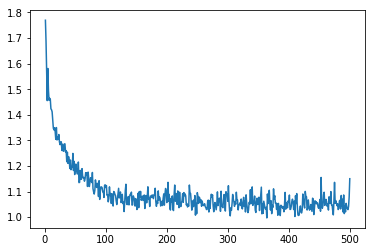

In [73]:
#plot loss
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss)


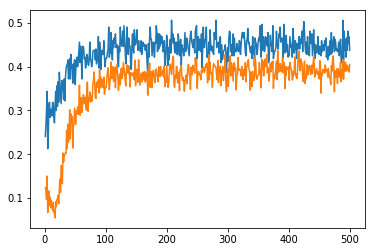

In [74]:
#plot accuracy and f1
acc = history.history['acc']
f1 = history.history['f1']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc)
plt.plot(epochs,f1)


In [9]:
from sklearn import metrics
#training and dev prediction
y_hat_train = model.predict(X_train)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_train, y_hat_train)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_train, y_hat_train,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_train, y_hat_train))

320/320 [==============================] - 0s 104us/step
accuracy:   0.347
classification report:
             precision    recall  f1-score   support

     Normal       0.28      1.00      0.44        80
         AF       0.00      0.00      0.00        80
      Other       0.92      0.29      0.44        80
      Noise       1.00      0.10      0.18        80

avg / total       0.55      0.35      0.26       320

confusion matrix:
[[80  0  0  0]
 [80  0  0  0]
 [57  0 23  0]
 [70  0  2  8]]


/home/obarquero/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
from sklearn import metrics
#training and dev prediction
y_hat_dev = model.predict(X_dev)

target_names = ['Normal','AF','Other','Noise']



score = metrics.accuracy_score(y_dev, y_hat_dev)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_dev, y_hat_dev,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_dev, y_hat_dev))

80/80 [==============================] - 0s 69us/step
accuracy:   0.250
classification report:
             precision    recall  f1-score   support

     Normal       0.25      0.90      0.39        20
         AF       0.00      0.00      0.00        20
      Other       0.29      0.10      0.15        20
      Noise       0.00      0.00      0.00        20

avg / total       0.13      0.25      0.13        80

confusion matrix:
[[18  0  2  0]
 [20  0  0  0]
 [17  0  2  1]
 [17  0  3  0]]


/home/obarquero/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
